# Fakebusters: Poster Result Generation

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
#--------------------------------DEFINE USER IDENTITIES-----------------------------------
identities=np.array(['bernie','biden','hillary','justin','may','michelle','modi','obama','pelosi','putin','trump','warren'])
lastNames = np.array(['Sanders','Biden','Clinton','Trudeau','May','Michelle','Modi','Obama','Pelosi','Putin','Trump','Warren'])

sid = np.argsort(lastNames)

print(lastNames[sid])

['Biden' 'Clinton' 'May' 'Michelle' 'Modi' 'Obama' 'Pelosi' 'Putin'
 'Sanders' 'Trudeau' 'Trump' 'Warren']


In [106]:
all_segments = '/Users/shrutiagarwal/Documents/MATLAB/bkup/'
from data_utils import get_vid_stats

out_seg_stats = 'full_dataset_stat.csv'

if not os.path.exists(out_seg_stats):
    seg_df = get_vid_stats(all_segments)
    seg_df.to_csv(out_seg_stats)

seg_df = pd.read_csv(out_seg_stats)

#number of segments
total_videos = seg_df[['video_id', 'duration']].loc[seg_df['user_id'].isin(identities)].groupby(seg_df['user_id'])
print(total_videos.count().sum())

print(total_videos.sum().sum()/3600)

video_id    4311
duration    4311
dtype: int64
duration    40.126694
dtype: float64


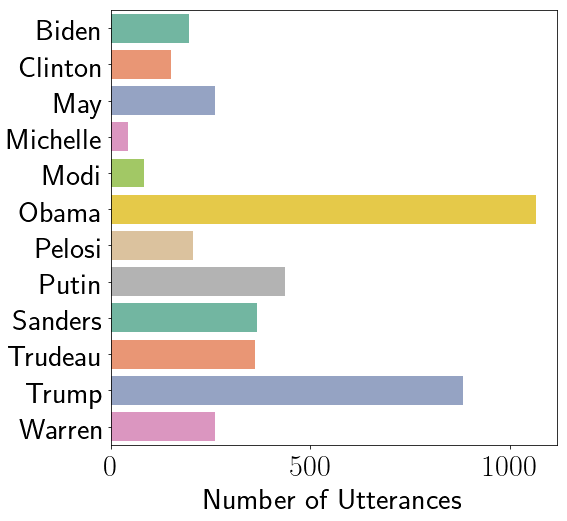

In [85]:
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)

plt.figure(figsize=(8, 8))

#number of segments
total_videos = seg_df['video_id'].loc[seg_df['user_id'].isin(identities)].groupby(seg_df['user_id']).count()
b = sns.barplot(y=total_videos.index, x= total_videos, orient='h', palette='Set2', order=identities[sid])
b.set_yticklabels(lastNames[sid])
b.set_xlabel(r'Number of Utterances',fontsize=30)
b.set_ylabel('')
b.tick_params(labelsize=30)
plt.draw()
plt.savefig('poster/utt_cnt.png', bbox_inches='tight', format='png', dpi=512)
plt.show()

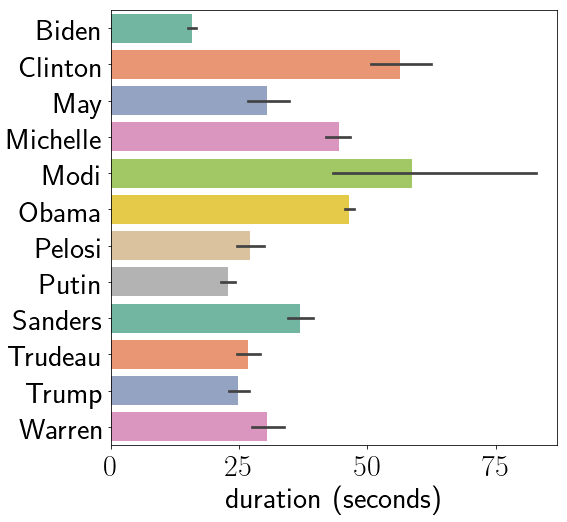

In [86]:
plt.figure(figsize=(8, 8))

#average duration of segments
sns.set_palette('gray')
b = sns.barplot(y=seg_df['user_id'], x= seg_df['duration'], orient='h', palette='Set2', order=identities[sid])
b.set_yticklabels(lastNames[sid])
b.set_xlabel(r'duration (seconds)',fontsize=30)
b.set_ylabel('')
b.tick_params(labelsize=30)
plt.draw()
plt.savefig('poster/utt_dur.png', bbox_inches='tight', format='png', dpi=512)
plt.show()

Shown below are the duration split for train, validation and test dataset.

### example

Shown below are the example frames from train, validation and test dataset for all the POIs. 

In [32]:
from data_utils import get_example_face
import re
import cv2

splits = ['dataset']
for s in range(len(splits)):
    for i in range(len(identities)):
        cur_path = seg_df[np.logical_and(seg_df['user_id']==identities[i], 
                                         seg_df['split']==splits[s])]['file_path'].sample(n=1, random_state=0).iloc[0]
        face = get_example_face(re.sub('.csv', '.mp4', cur_path), face_size=(512, 512))
        face = np.squeeze(face[0, :, :, :]).astype('uint8')
        face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
        cv2.imwrite('poster/{}.png'.format(identities[i]), face)
        
        

### fake videos

For fake videos, we used two types of datasets. As we exploit the facial expressions of the person when they talk, we used videos where the POI speaking style was impersonated by someone else. In addition to this, we created faceswap videos for the POIs.

Below we show the duration of videos we have for each POI and example frames. Notice there were no faceswap or imposter videos collected for many POIs. But we believe we have enough videos to validate our technique.

In [4]:
all_segments = 'fakes'
from data_utils import get_vid_stats_fake

out_seg_stats = 'fake_stat.csv'

if not os.path.exists(out_seg_stats):
    fake_df = get_vid_stats_fake(all_segments)
    fake_df.to_csv(out_seg_stats)

fake_df = pd.read_csv(out_seg_stats)
print(fake_df[fake_df['split']=='face_swap'].count())
print(fake_df[fake_df['split']=='face_swap'].sum())

Unnamed: 0    100
split         100
user_id       100
video_id      100
no_frames     100
file_path     100
duration      100
dtype: int64
Unnamed: 0                                                17650
split         face_swapface_swapface_swapface_swapface_swapf...
user_id       hillaryhillaryhillaryhillaryhillaryhillaryhill...
video_id      2_output26_output11_output7_output14_output23_...
no_frames                                                 80229
file_path     fakes/face_swap/hillary/2_output.csvfakes/face...
duration                                                 2674.3
dtype: object


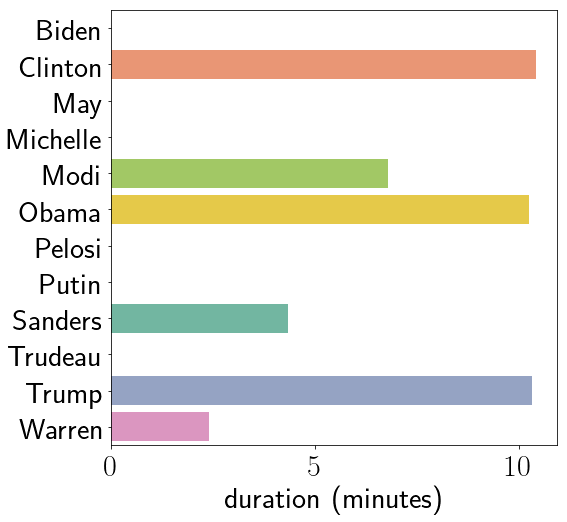

In [5]:
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)


total_minutes = fake_df[fake_df['split']=='face_swap'].groupby(['user_id', 'split'])['duration'].agg('sum').reset_index()
total_minutes['duration'] = total_minutes['duration']/60

plt.figure(figsize=(8, 8))
b = sns.barplot(y=total_minutes['user_id'], x= total_minutes['duration'], 
                orient='h', order=identities[sid], palette='Set2')
b.set_yticklabels(lastNames[sid])
b.set_xlabel(r'duration (minutes)',fontsize=30)
b.set_ylabel('')
b.tick_params(labelsize=30)
plt.draw()
plt.savefig('poster/fake_dur.png', bbox_inches='tight', format='png', dpi=512)
plt.show()


In [8]:
from data_utils import get_example_face
import re
import cv2

splits = ['face_swap', 'imposter']

pois = []

for i in range(len(identities)):
    cur_path_fs = fake_df[np.logical_and(fake_df['user_id']==identities[i], 
                                     fake_df['split']==splits[0])]['file_path']

    if len(cur_path_fs)>0:
        pois.extend([identities[i]])

for s in range(len(splits)):
    for i in range(len(pois)):
        cur_path = fake_df[np.logical_and(fake_df['user_id']==pois[i], 
                                         fake_df['split']==splits[s])]['file_path'].sample(n=1, random_state=0).iloc[0]
        face = get_example_face(re.sub('.csv', '.mp4', cur_path))
        face = np.squeeze(face[0, :, :, :]).astype('uint8')
        face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
        cv2.imwrite('poster/{}{}.png'.format(splits[s], pois[i]), face)
        

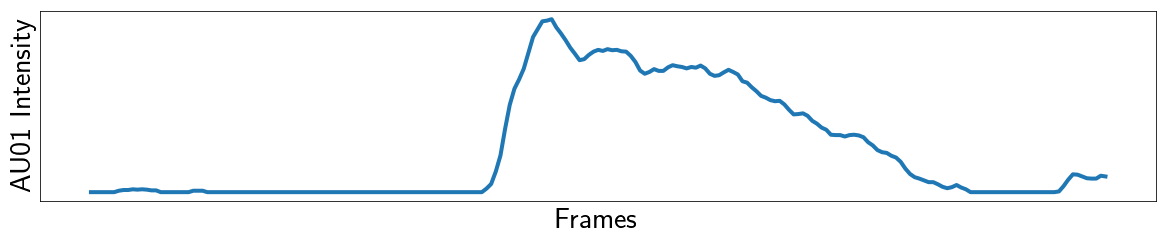

In [9]:
aus = np.array(pd.read_csv('openface/-my9hVoGv2M_4.csv')[' AU01_r'])
idx = np.argmax(aus)
plt.figure(figsize=(20, 3.5))
fr_nm = np.arange(idx-99, idx+120)
plt.plot(aus[fr_nm], linewidth=4)
plt.xlabel(r'Frames', fontsize=30)
plt.ylabel(r'AU01 Intensity', fontsize=30)
plt.xticks([])
plt.yticks([])
plt.draw()
plt.savefig('poster/AU01.png', bbox_inches='tight', format='png', dpi=512)
plt.show()